In [1]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

2024-06-16 21:09:14.624867: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 21:09:14.649281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 21:09:14.983673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cjj/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end

In [2]:

f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(0,sample_num),size=60000)
# idx = np.random.choice(range(0,sample_num),size=30000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    if i%1 == 0:
        !free -m
    '''if i == 10:
        continue'''
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

               total        used        free      shared  buff/cache   available
Mem:          128494        3536      105559         113       19397      123620
Swap:           2047           0        2047
ExtractDataset/part1.h5
               total        used        free      shared  buff/cache   available
Mem:          128494        4010      105086         113       19397      123147
Swap:           2047           0        2047
ExtractDataset/part2.h5
               total        used        free      shared  buff/cache   available
Mem:          128494        4513      104583         113       19397      122644
Swap:           2047           0        2047
ExtractDataset/part3.h5
               total        used        free      shared  buff/cache   available
Mem:          128494        4944      104152         113       19397      122213
Swap:           2047           0        2047
ExtractDataset/part4.h5
               total        used        free      shared  buff/cache   avail

In [3]:
n_examples = X.shape[0]
n_train = int(n_examples * 0.8)   
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (1152000, 1024, 2)
Y_train: (1152000, 24)
X_test: (288000, 1024, 2)
Y_test: (288000, 24)


In [4]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights 
    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output
    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    def get_config(self):
        cfg = super().get_config()
#         cfg.update({
#             'att': self.MultiHeadSelfAttention(1024, 128),
#             'ffn': self.tf.keras.Sequential(
#             [layers.Dense(256, activation="relu"), layers.Dense(1024),]
#         ),
#             'layernorm1': self.layers.LayerNormalization(epsilon=1e-6),
#             'layernorm2': self.layers.LayerNormalization(epsilon=1e-6),
#             'dropout1': self.Dropout(0.2),
#             'dropout2': self.Dropout(0.2),
#         })
        return cfg    
    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
def proposed_model(X_train,classes):

    embed_dim = 1024  # Embedding size for each token
    num_heads = 128  # Number of attention heads
    ff_dim = 256  # Hidden layer size in feed forward network inside transformer

#     inputs = layers.Input(shape=(maxlen,))
#     embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#     x = embedding_layer(inputs)
#     mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
#     with mirrored_strategy.scope():
    in_shp = X_train.shape[1:]   #Dimensions of each sample

    #input layer
    X_input = Input(in_shp)
    X = Reshape([2,1024], input_shape=in_shp)(X_input)

    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(X)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.AlphaDropout(0.3)(x)
    x = layers.Dense(128, activation="selu")(x)
    x = layers.AlphaDropout(0.2)(x)
    x = layers.Dense(128, activation="selu")(x)
    x = layers.AlphaDropout(0.2)(x)
    x = layers.Dense(24, activation="softmax")(x)

    return tf.keras.models.Model(inputs=X_input, outputs=x)     
    
model_trafo = proposed_model(X_train,classes)    
model_trafo.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.LazyAdam(),metrics=['accuracy'])
model_trafo.load_weights('trafo_model')
model_trafo.summary()

2024-06-16 21:09:43.973383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-16 21:09:43.989912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-16 21:09:43.990019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 2)]         0         
                                                                 
 reshape (Reshape)           (None, 2, 1024)           0         
                                                                 
 transformer_block (Transfor  (None, 2, 1024)          4728064   
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 1024)             0         
 lobalAveragePooling1D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                             

In [5]:
model_resnet = load_model('resnet_model_mix.h5')
#model_trafo = load_model('transformer_model.h5')

2024-06-16 21:09:46.596938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-16 21:09:46.599995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2024-06-16 21:09:46.662169: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-06-16 21:09:46.662187: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-06-16 21:09:46.662229: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


96/96 [==============================] - 12s 109ms/step
32PSK 0.7492142266335815
16APSK 0.6917989417989417
32QAM 0.7064243448858833
FM 0.7524522028262677
GMSK 0.657944853854434
32APSK 0.6205543496410085
OQPSK 0.5283208020050125
8ASK 0.6663607542132488
BPSK 0.6435546073685074
8PSK 0.6340835478780832
AM-SSB-SC 0.5936465916611515
4ASK 0.5507845453011642
16PSK 0.609819555182543
64APSK 0.5817246902132681
128QAM 0.4983754061484629
128APSK 0.5733255871856585
AM-DSB-SC 0.500956500041587
AM-SSB-WC 0.2748735244519393
64QAM 0.7040501043841336
QPSK 0.6716890035794556
256QAM 0.6416342734265156
AM-DSB-WC 0.7746443723483903
OOK 0.7660229731979358
16QAM 0.7126234722919805


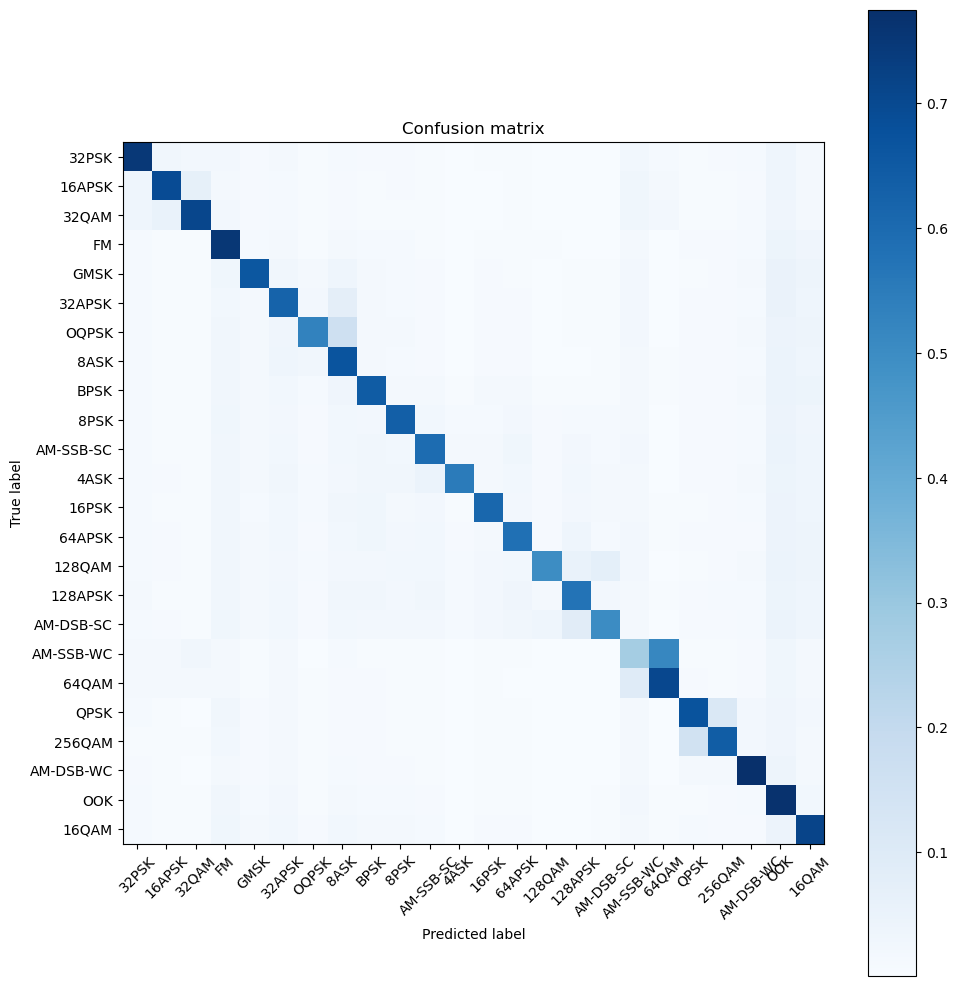

In [6]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model_resnet.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

343/343 [==============================] - 1s 2ms/step
Overall Accuracy -20:  0.2326090925689246
349/349 [==============================] - 1s 2ms/step
Overall Accuracy -18:  0.24015076729785514
349/349 [==============================] - 1s 2ms/step
Overall Accuracy -16:  0.23745399048388544
338/338 [==============================] - 1s 2ms/step
Overall Accuracy -14:  0.23993335184670925
353/353 [==============================] - 1s 2ms/step
Overall Accuracy -12:  0.24622758743120896
344/344 [==============================] - 1s 2ms/step
Overall Accuracy -10:  0.2674302336151259
346/346 [==============================] - 1s 2ms/step
Overall Accuracy -8:  0.2811539157171279
348/348 [==============================] - 0s 1ms/step
Overall Accuracy -6:  0.3187494385050759
342/342 [==============================] - 1s 2ms/step
Overall Accuracy -4:  0.36676112990218485
340/340 [==============================] - 1s 2ms/step
Overall Accuracy -2:  0.451535773404451
350/350 [=====================

/tmp/ipykernel_113543/4000962422.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


352/352 [==============================] - 1s 2ms/step
Overall Accuracy 2:  0.6752068321323725
349/349 [==============================] - 1s 2ms/step
Overall Accuracy 4:  0.7650856271855107
357/357 [==============================] - 1s 2ms/step
Overall Accuracy 6:  0.8472136902150066
346/346 [==============================] - 1s 2ms/step
Overall Accuracy 8:  0.8984445650207994
339/339 [==============================] - 1s 3ms/step
Overall Accuracy 10:  0.9320765178818963
338/338 [==============================] - 1s 2ms/step
Overall Accuracy 12:  0.9418292795708869
359/359 [==============================] - 1s 2ms/step
Overall Accuracy 14:  0.9473867899834221
345/345 [==============================] - 0s 1ms/step
Overall Accuracy 16:  0.9473827451691917
354/354 [==============================] - 1s 2ms/step
Overall Accuracy 18:  0.9470749623860518
347/347 [==============================] - 1s 2ms/step
Overall Accuracy 20:  0.9458972046889089
348/348 [==============================] - 0

<Figure size 640x480 with 0 Axes>

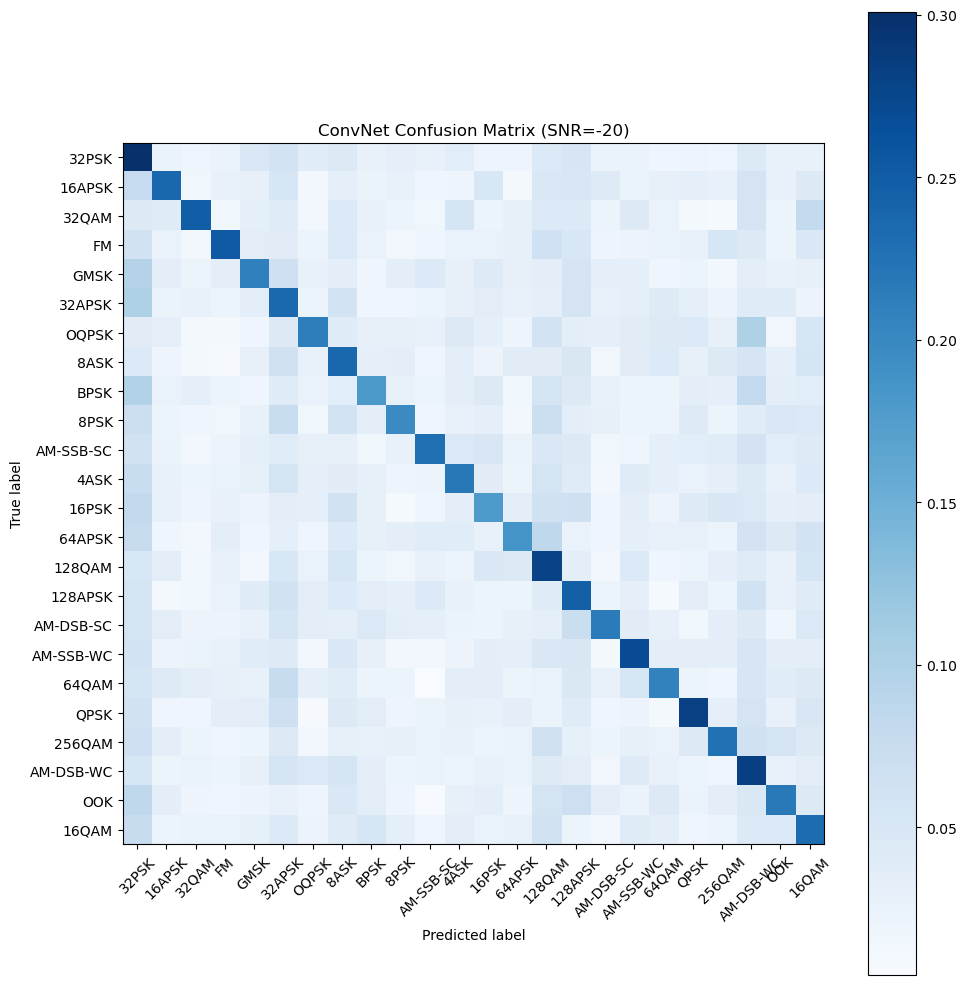

<Figure size 640x480 with 0 Axes>

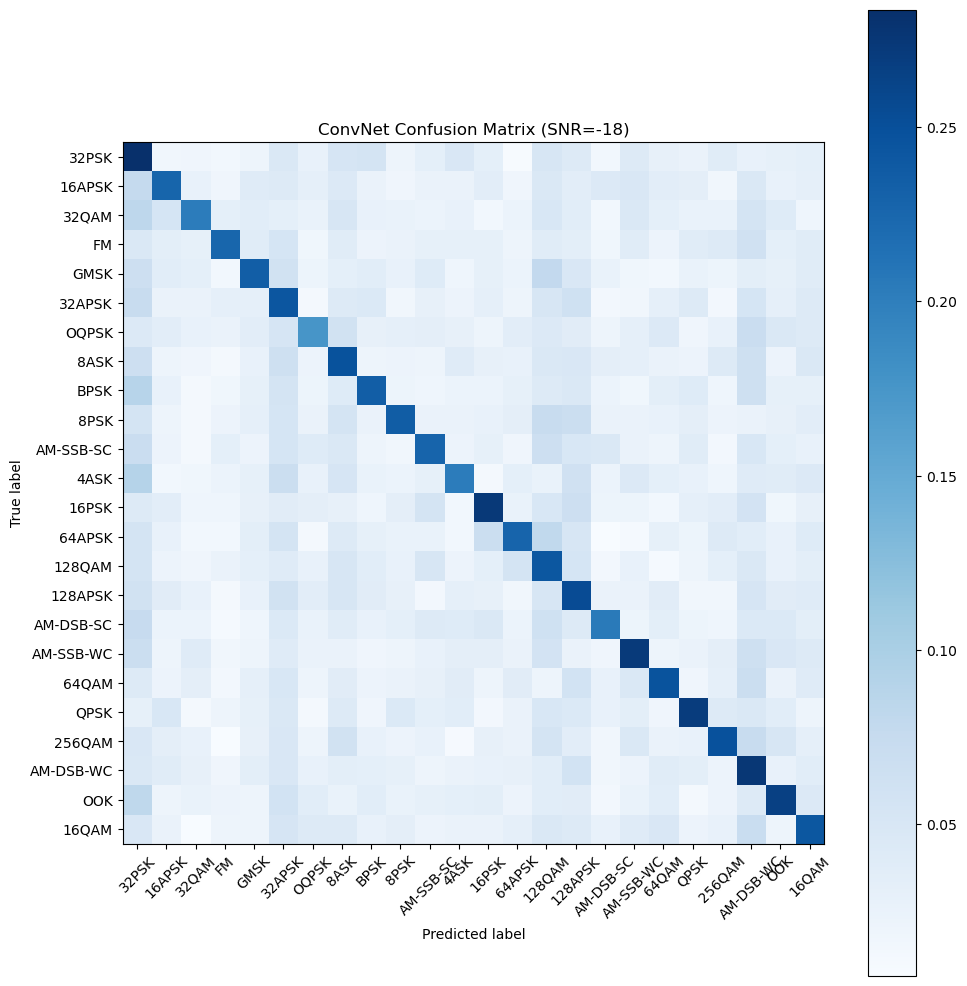

<Figure size 640x480 with 0 Axes>

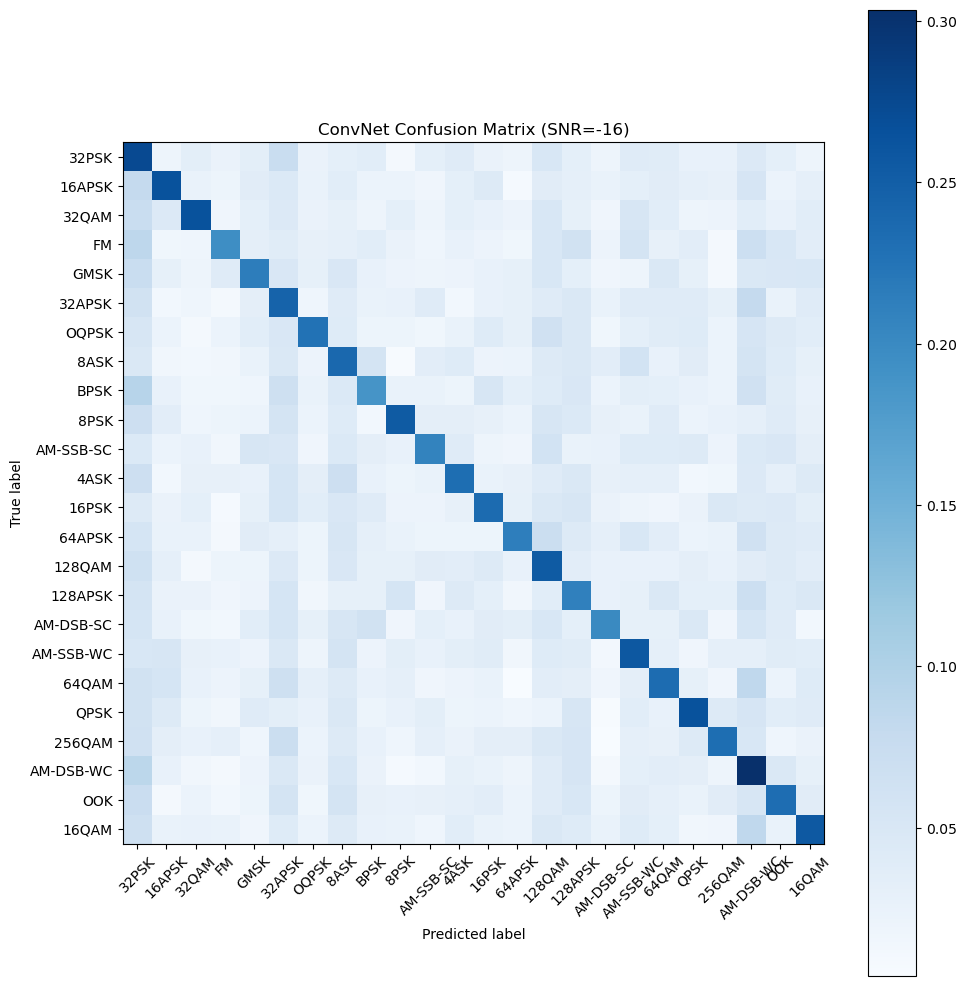

<Figure size 640x480 with 0 Axes>

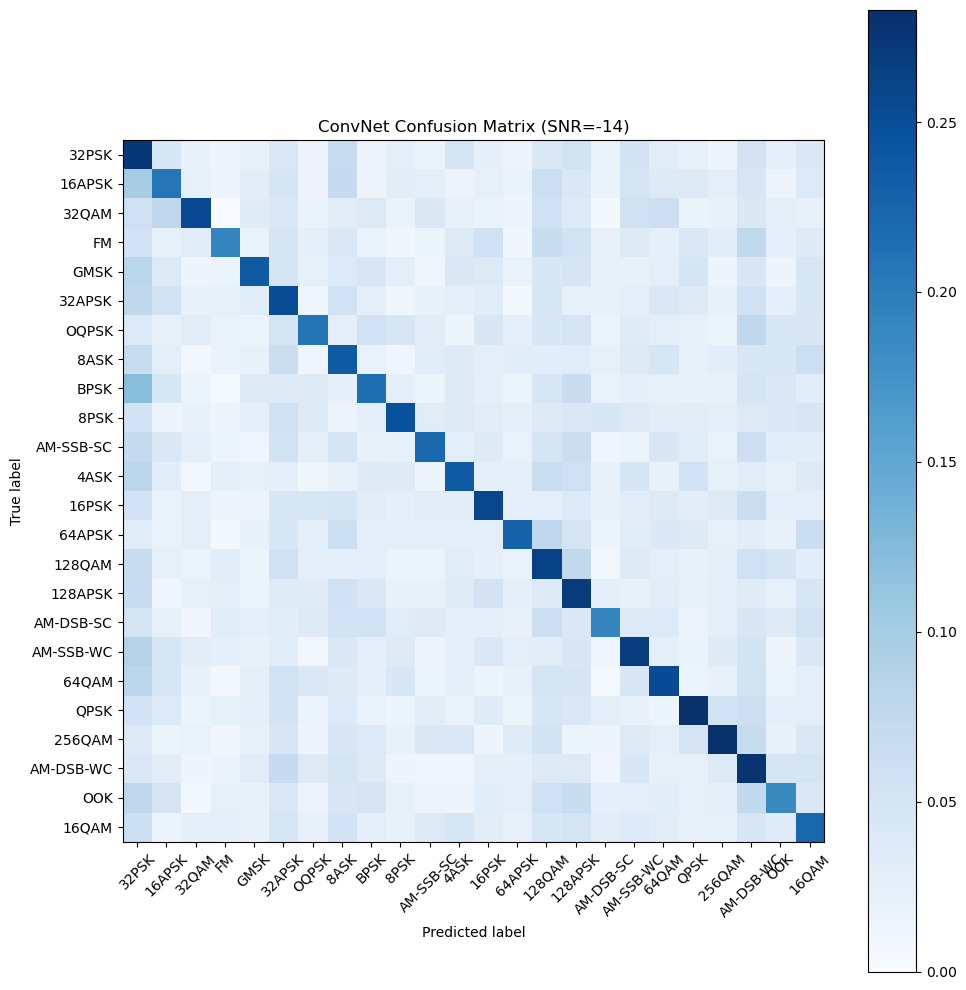

<Figure size 640x480 with 0 Axes>

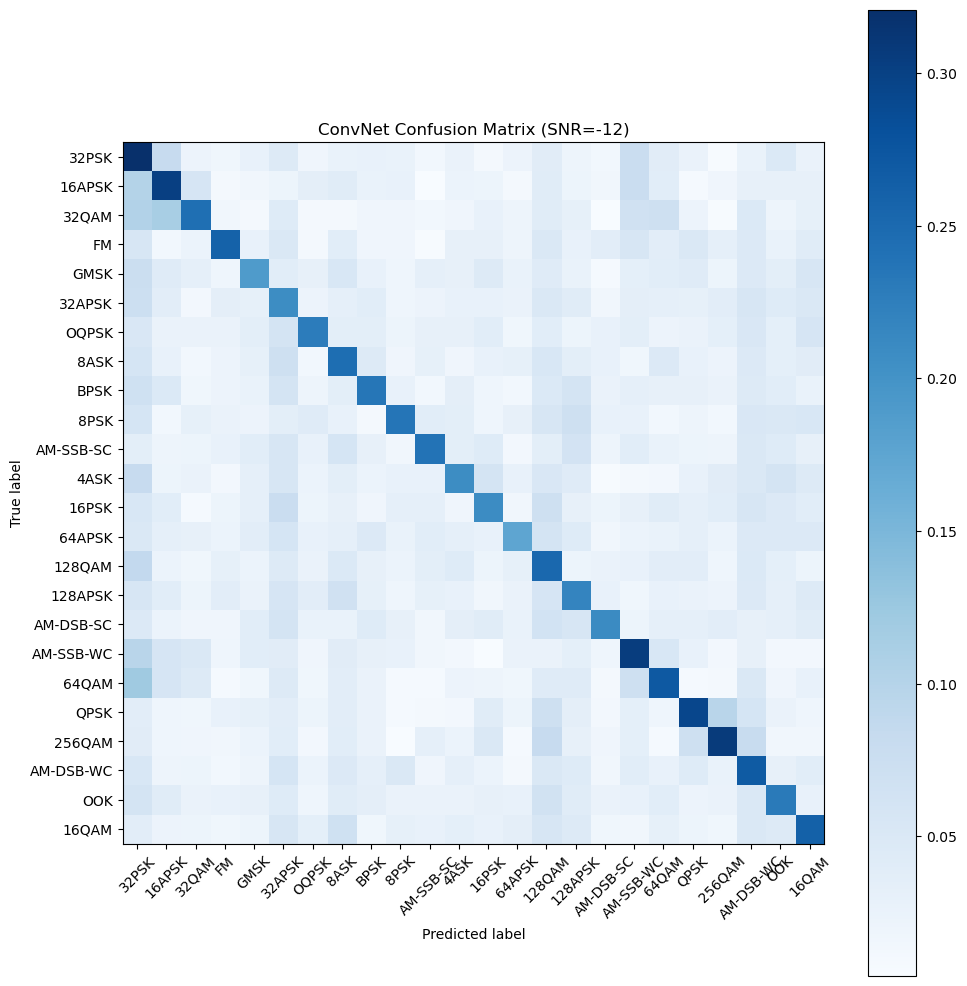

<Figure size 640x480 with 0 Axes>

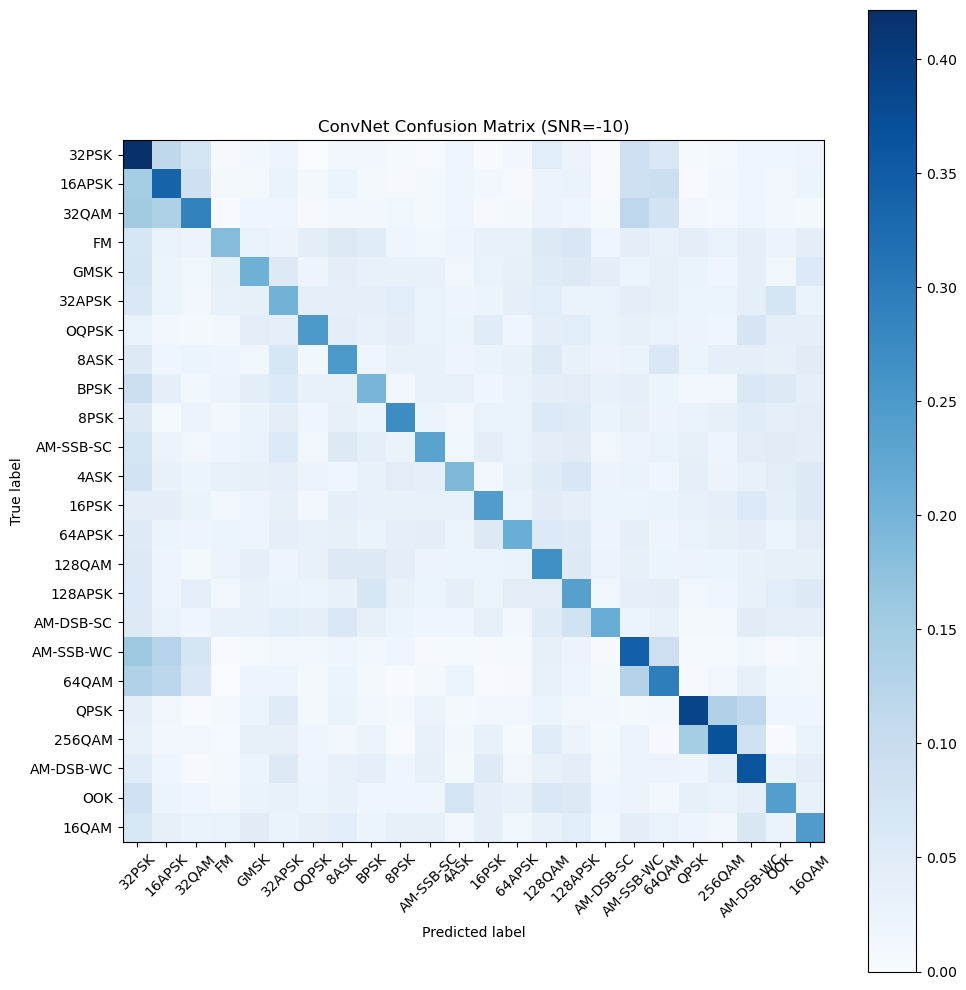

<Figure size 640x480 with 0 Axes>

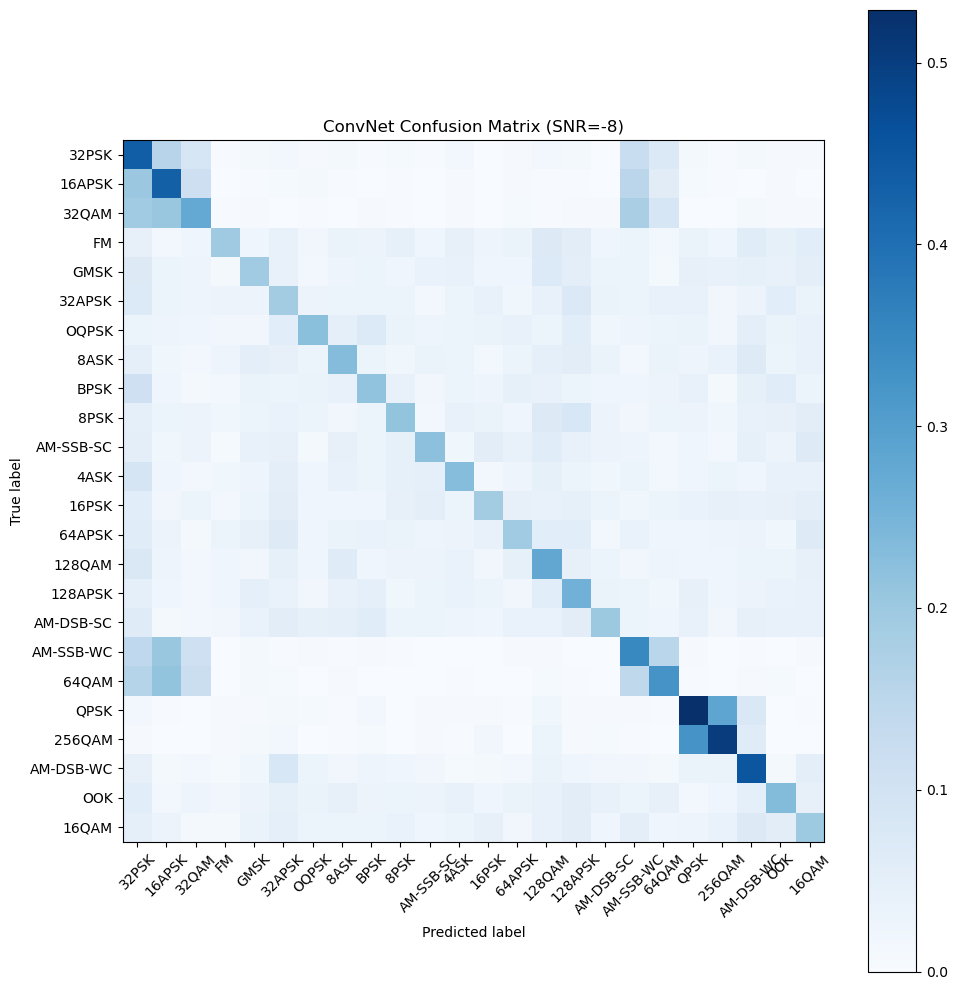

<Figure size 640x480 with 0 Axes>

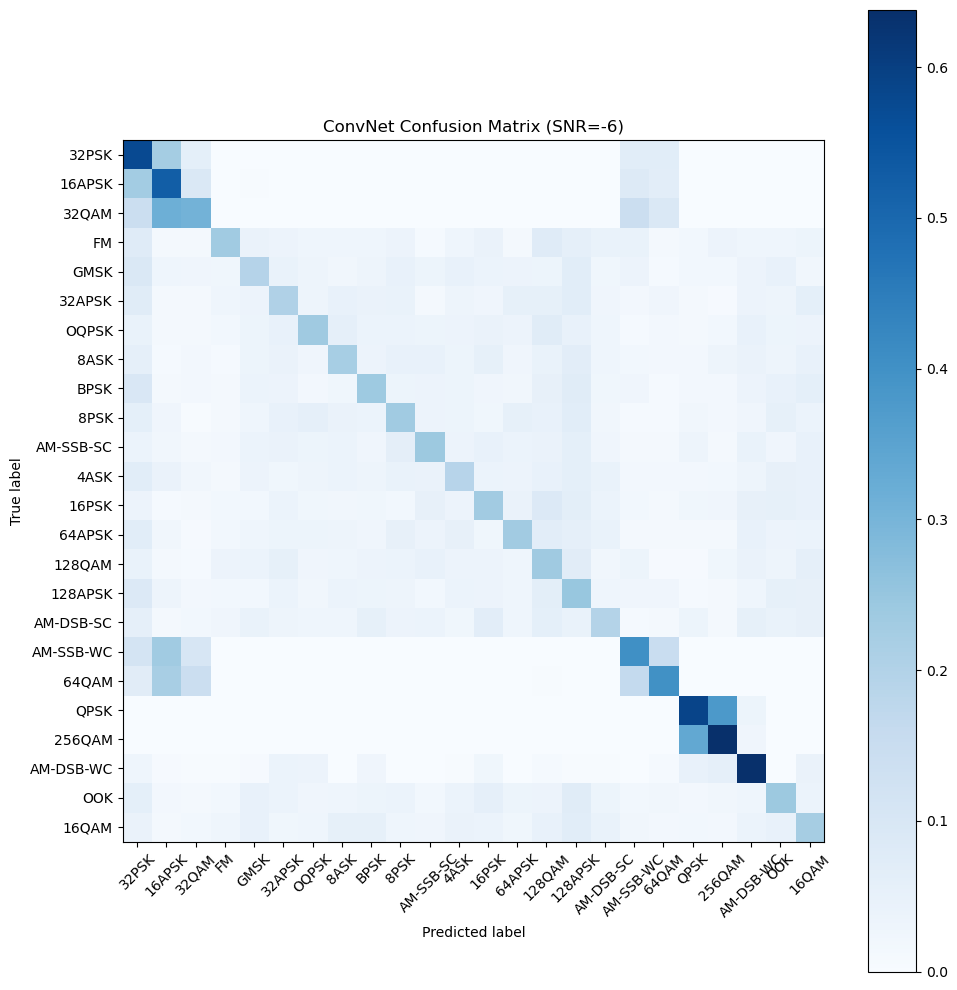

<Figure size 640x480 with 0 Axes>

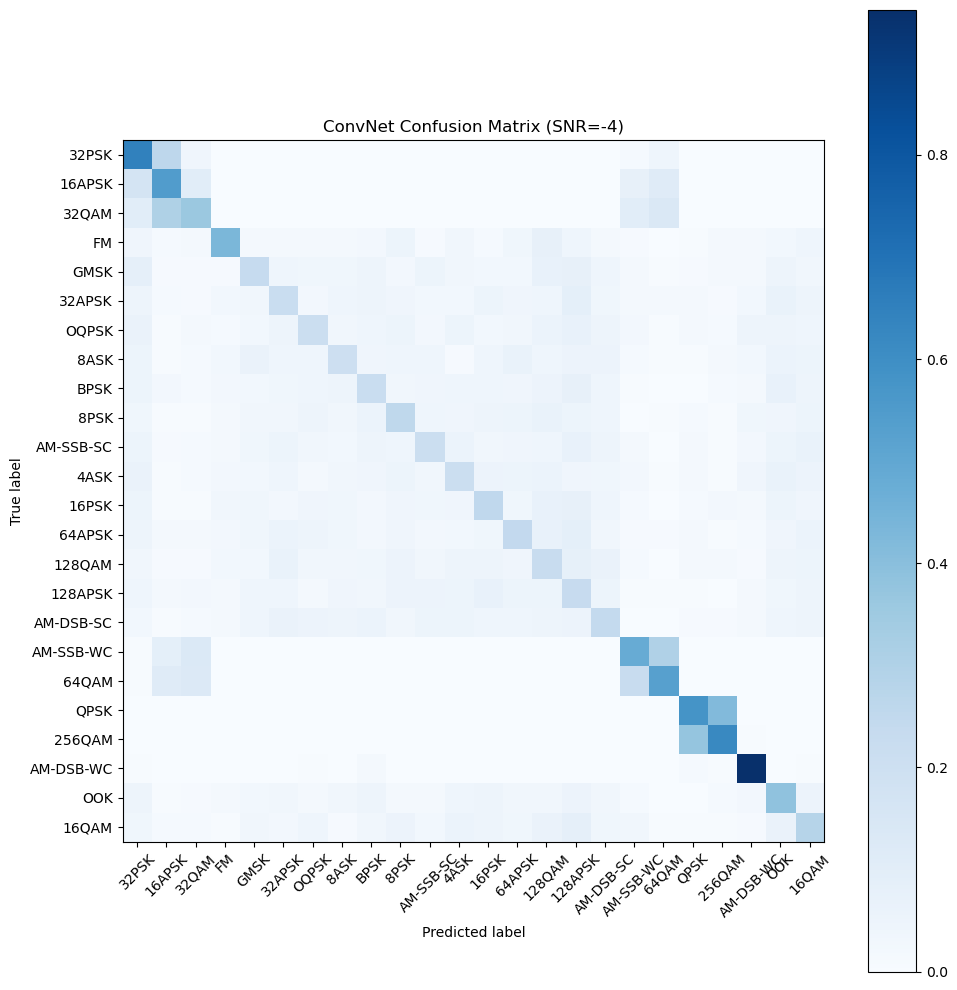

<Figure size 640x480 with 0 Axes>

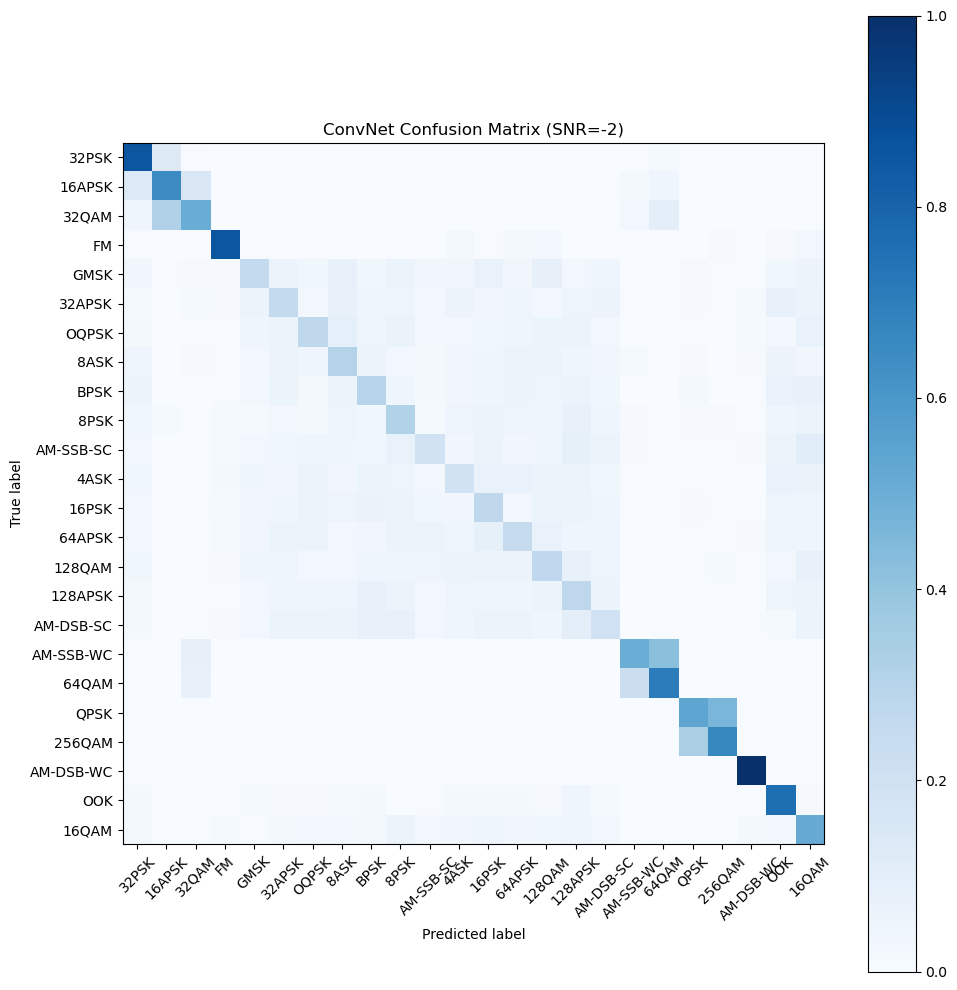

<Figure size 640x480 with 0 Axes>

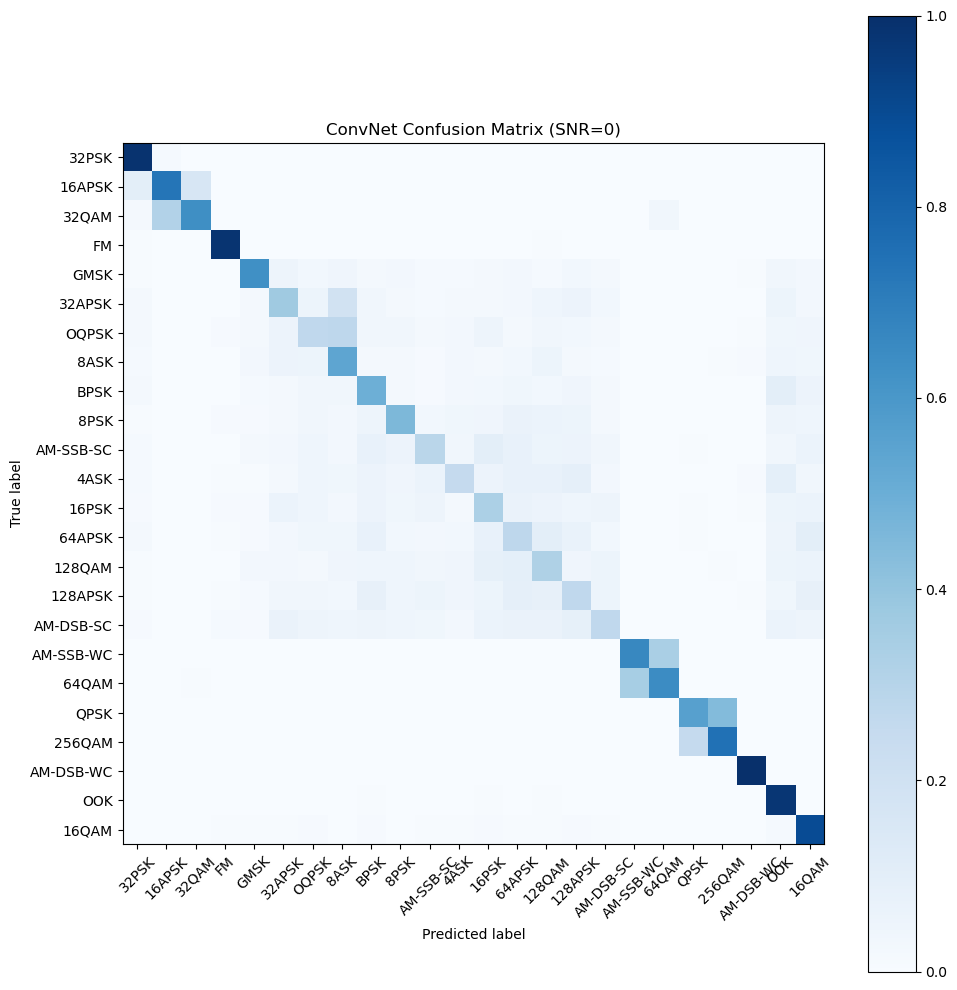

<Figure size 640x480 with 0 Axes>

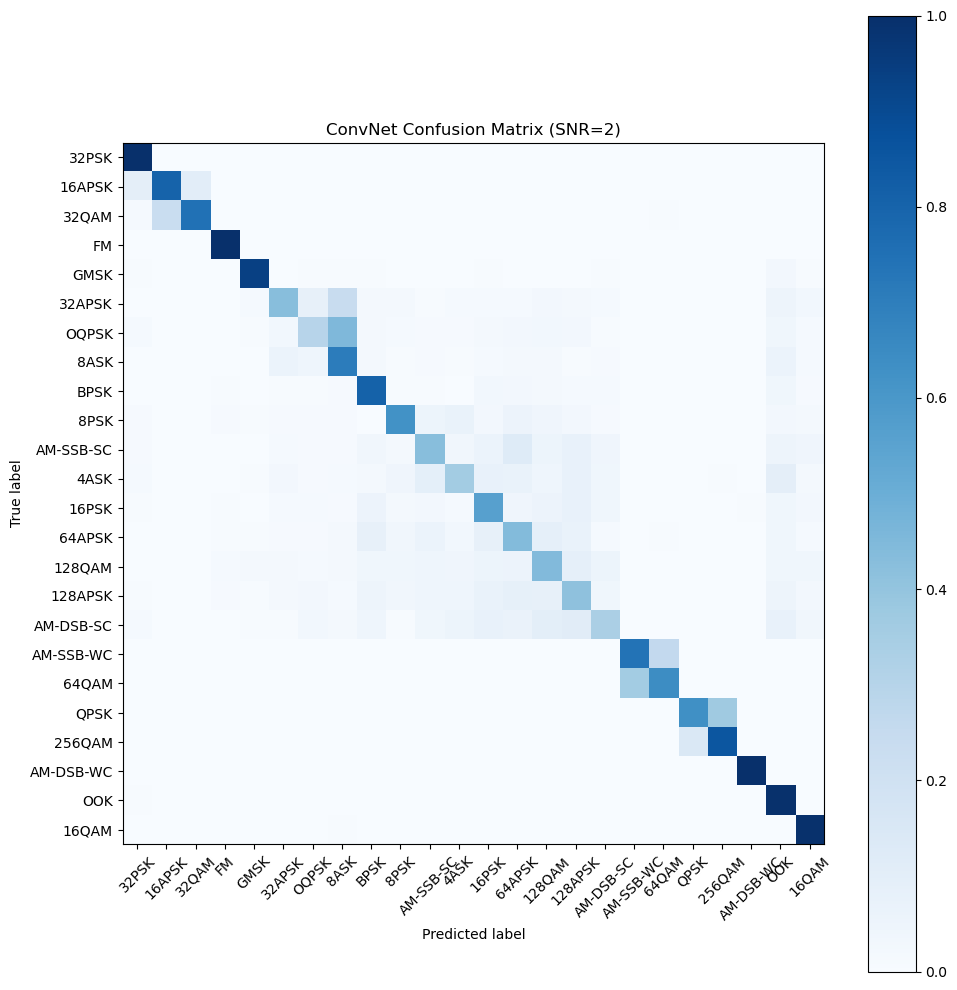

<Figure size 640x480 with 0 Axes>

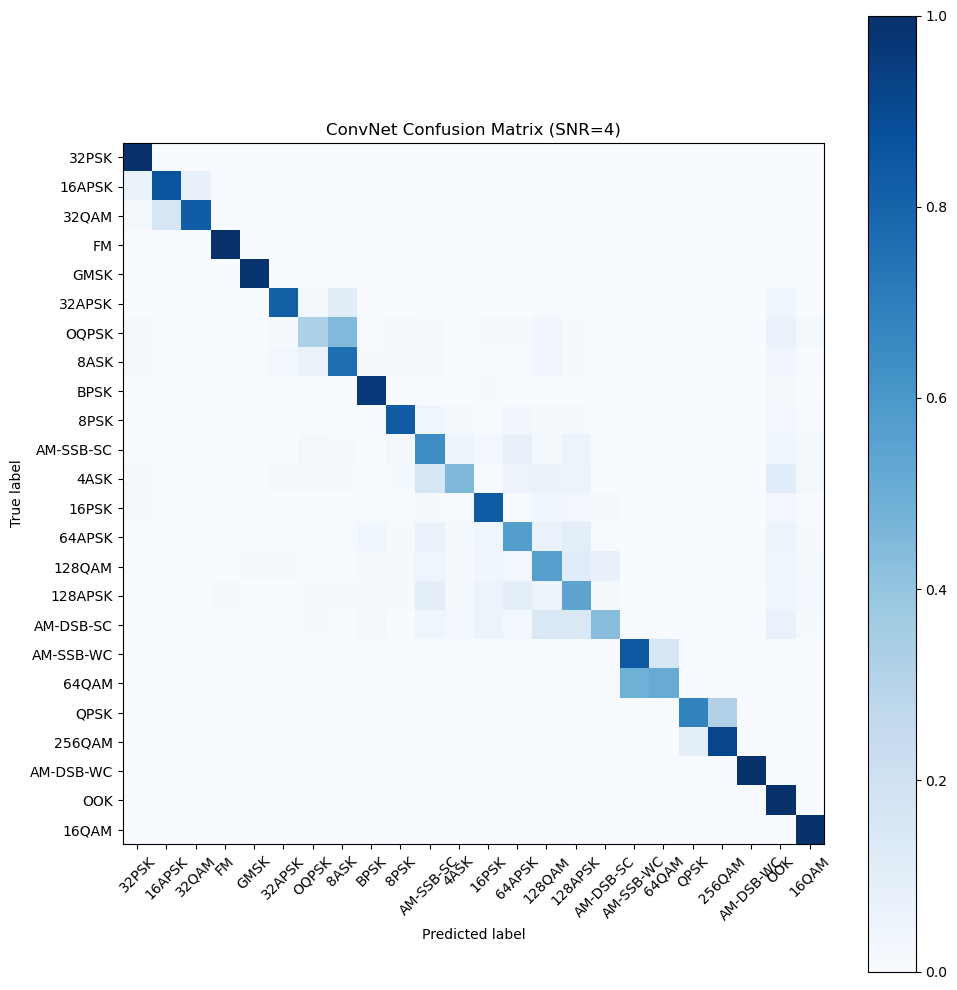

<Figure size 640x480 with 0 Axes>

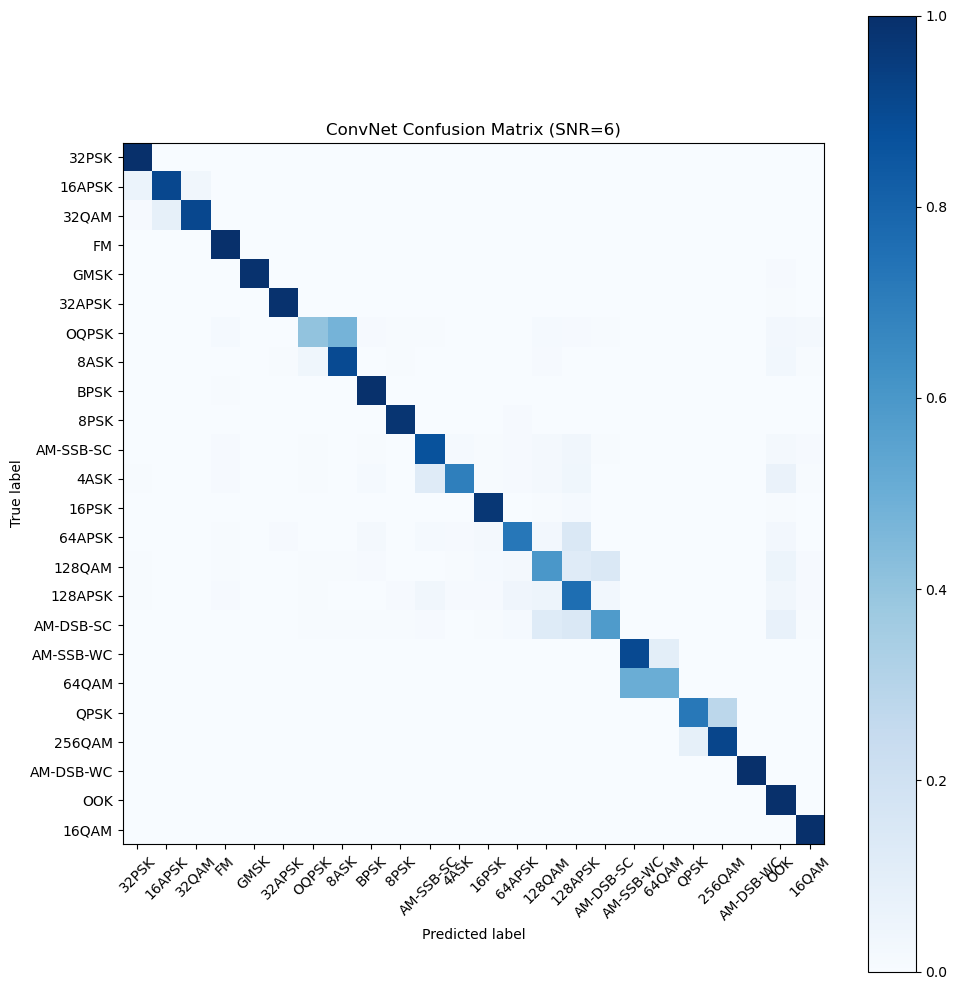

<Figure size 640x480 with 0 Axes>

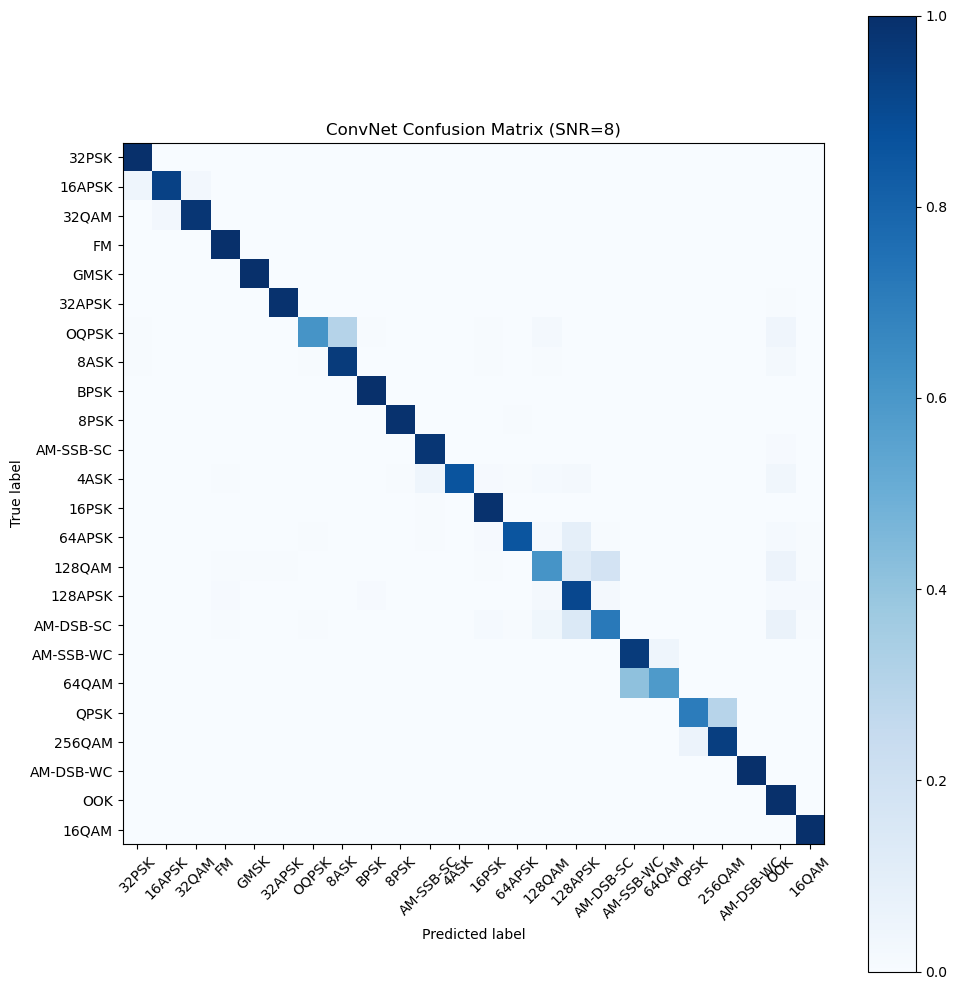

<Figure size 640x480 with 0 Axes>

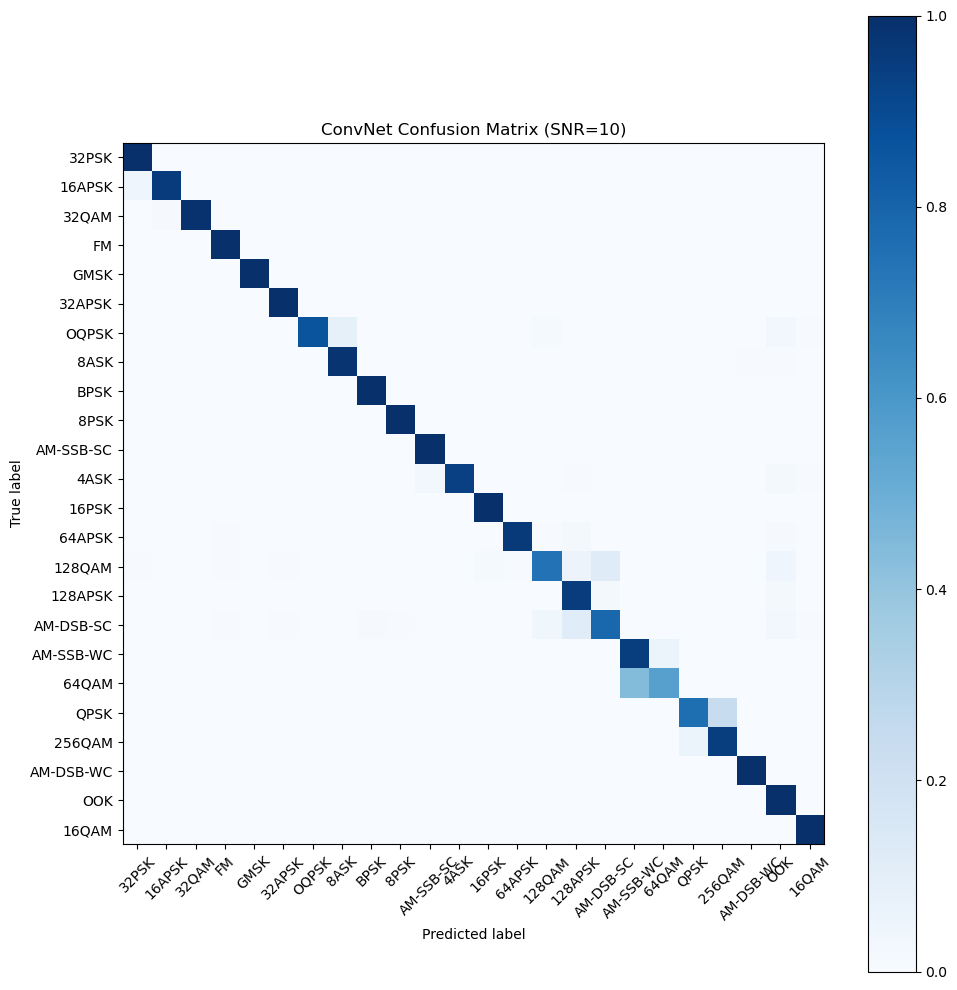

<Figure size 640x480 with 0 Axes>

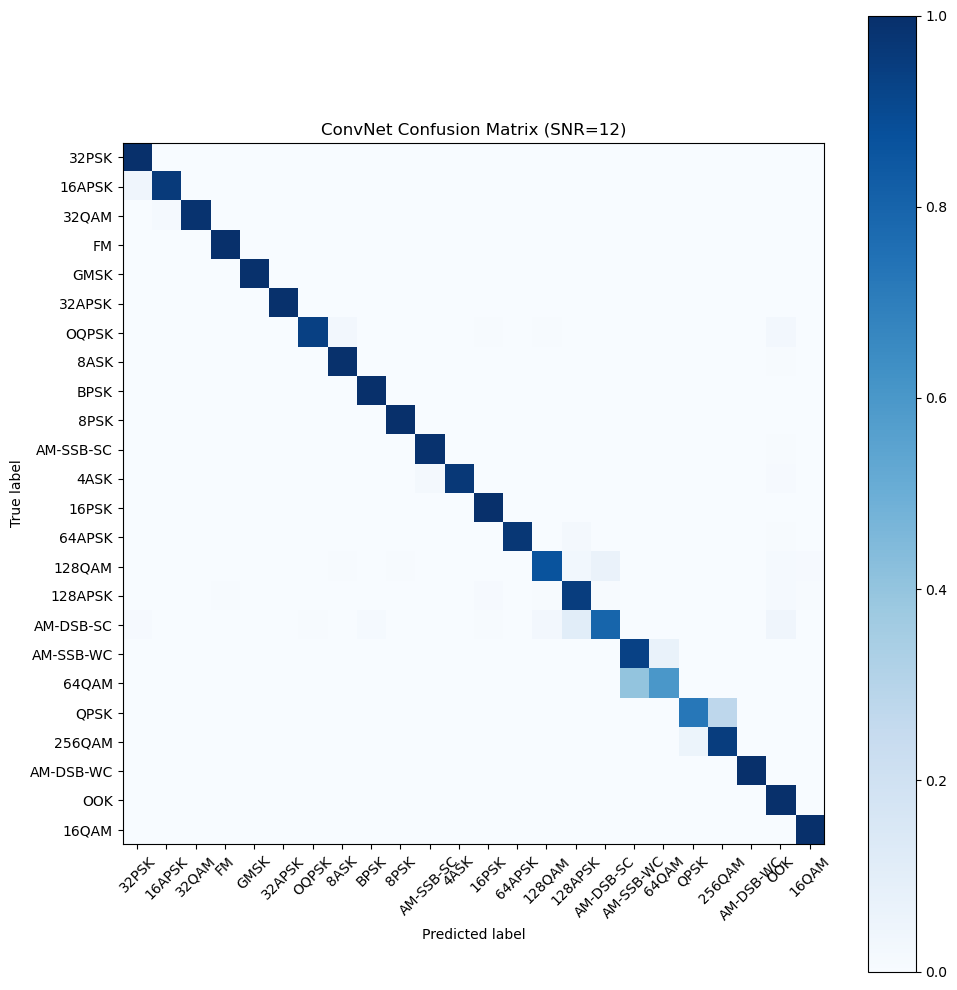

<Figure size 640x480 with 0 Axes>

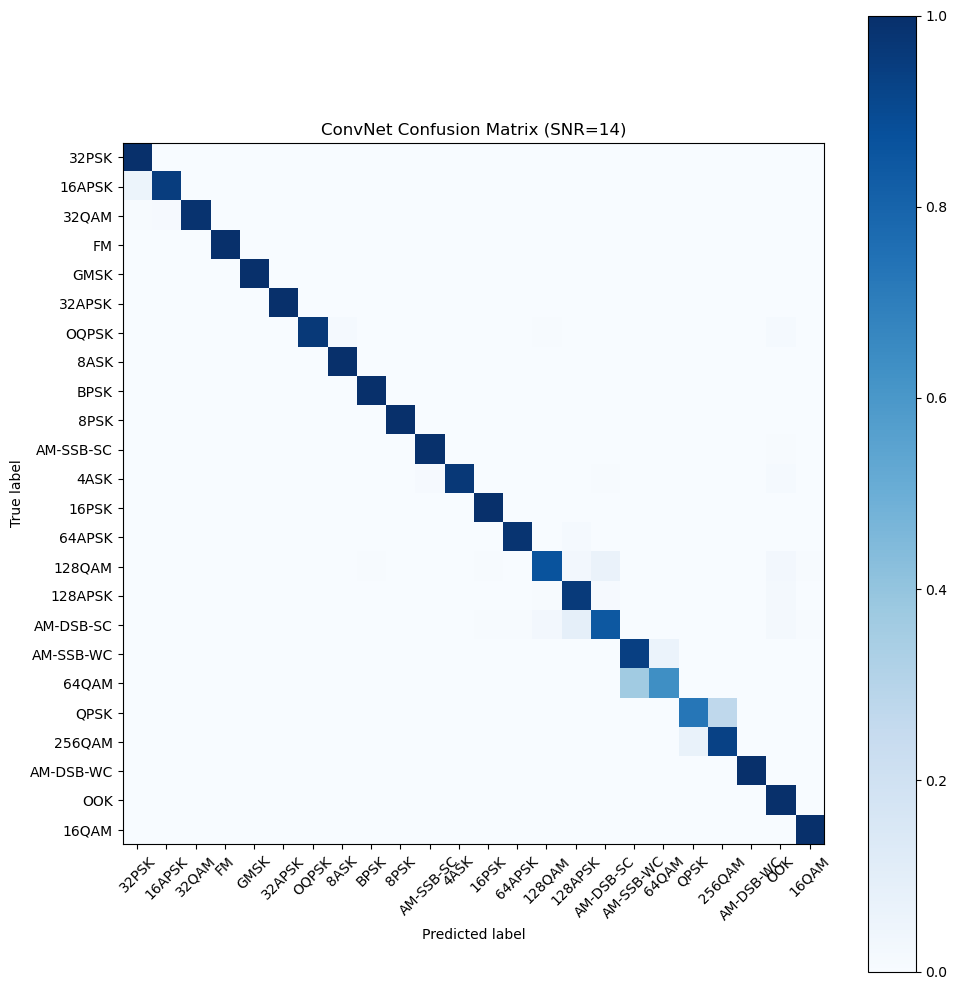

<Figure size 640x480 with 0 Axes>

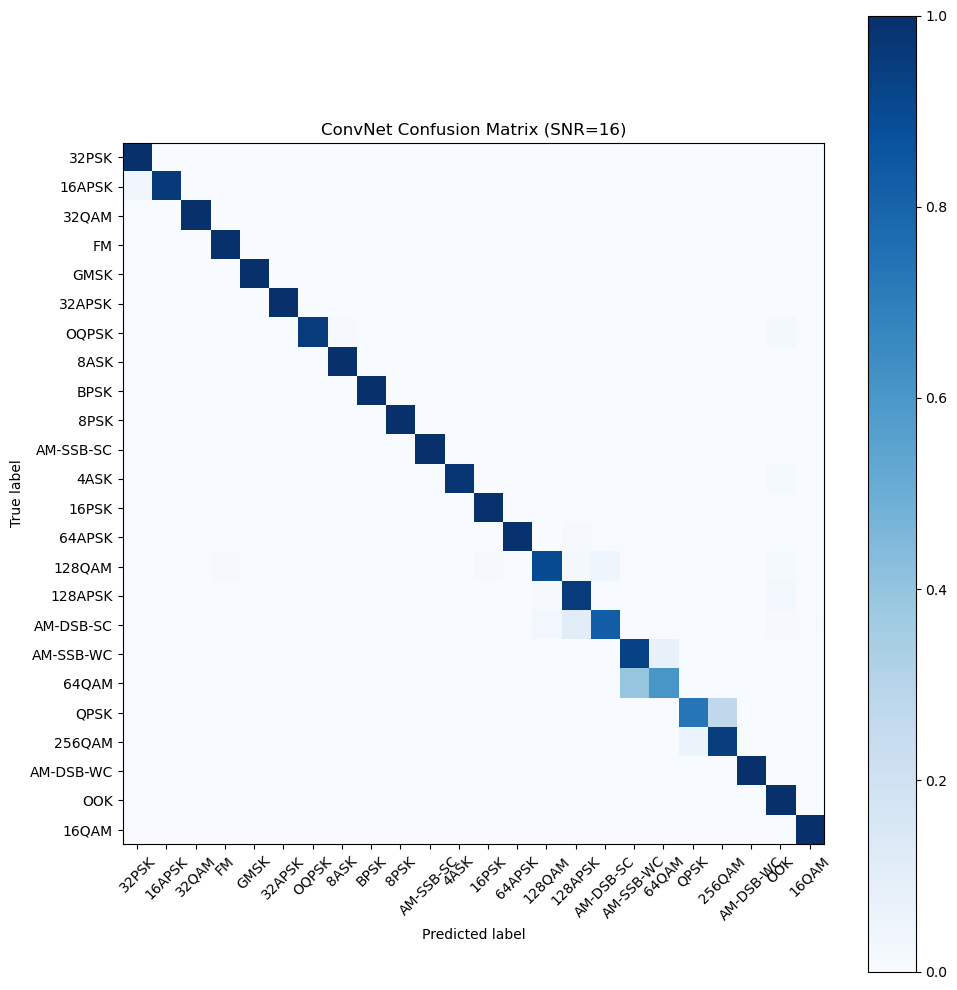

<Figure size 640x480 with 0 Axes>

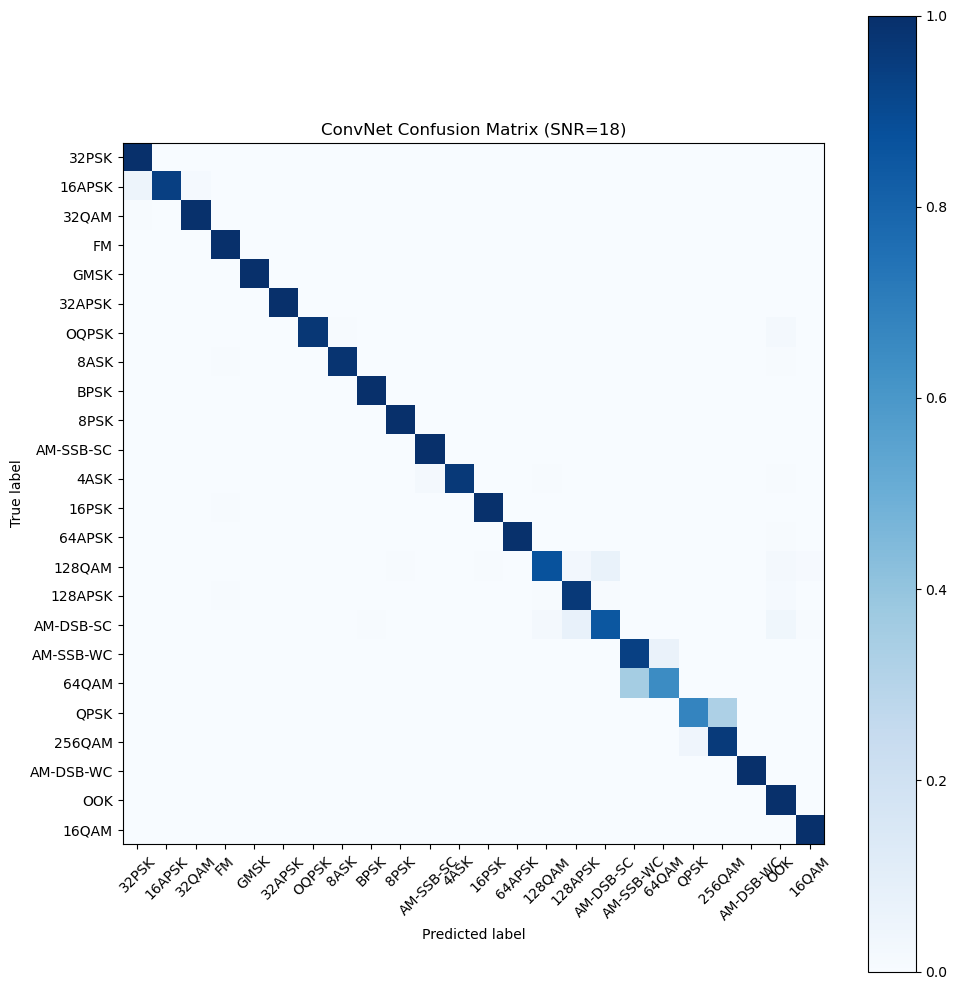

<Figure size 640x480 with 0 Axes>

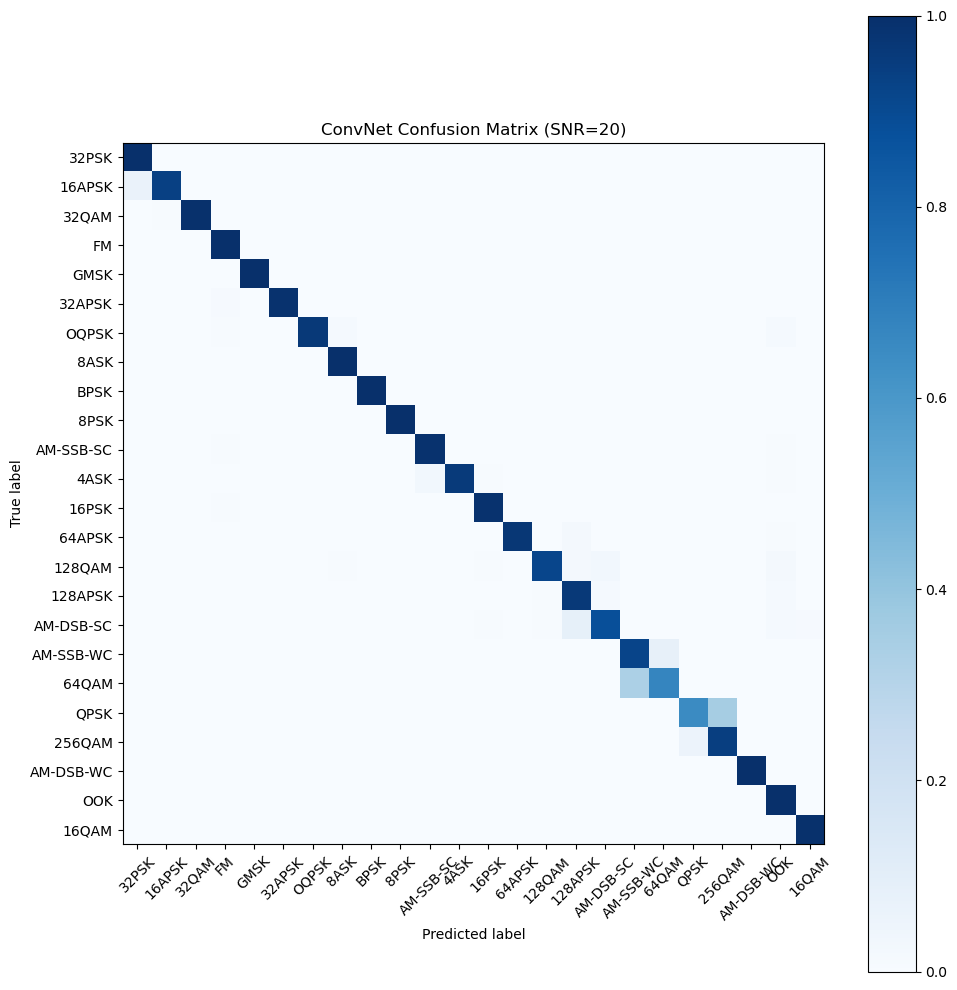

<Figure size 640x480 with 0 Axes>

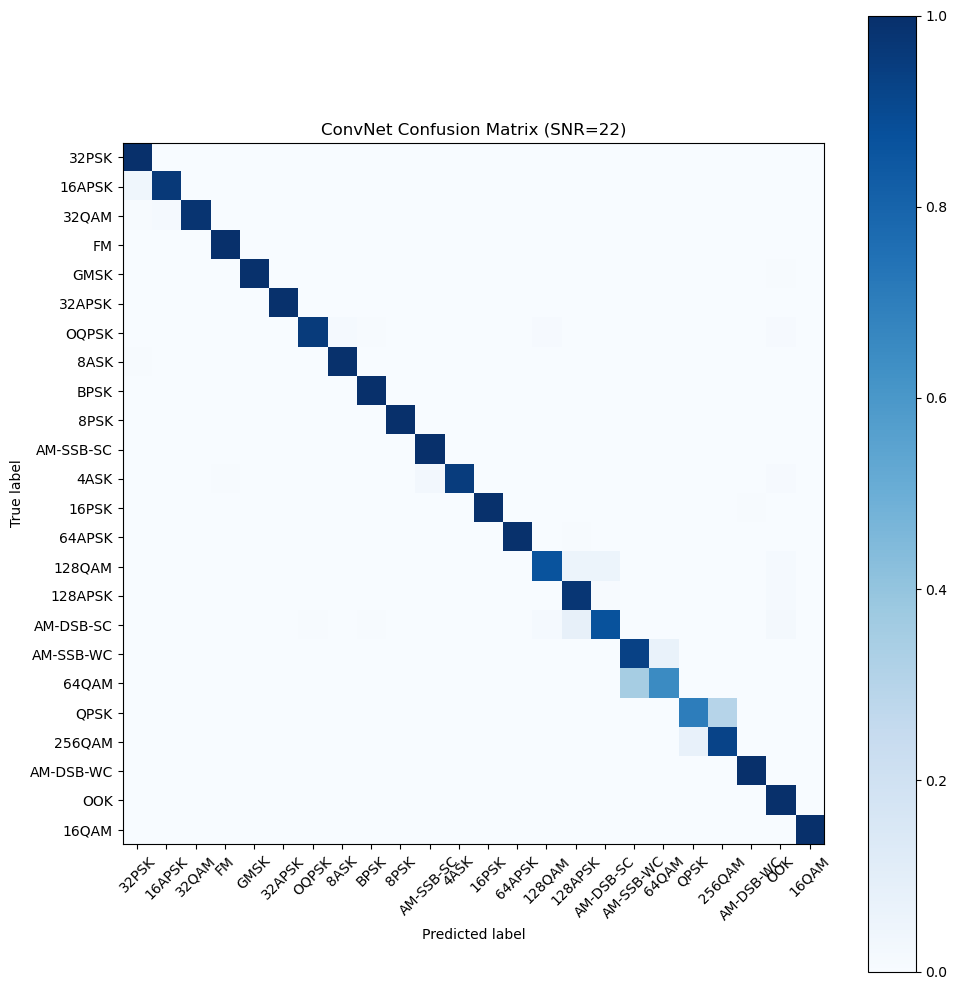

<Figure size 640x480 with 0 Axes>

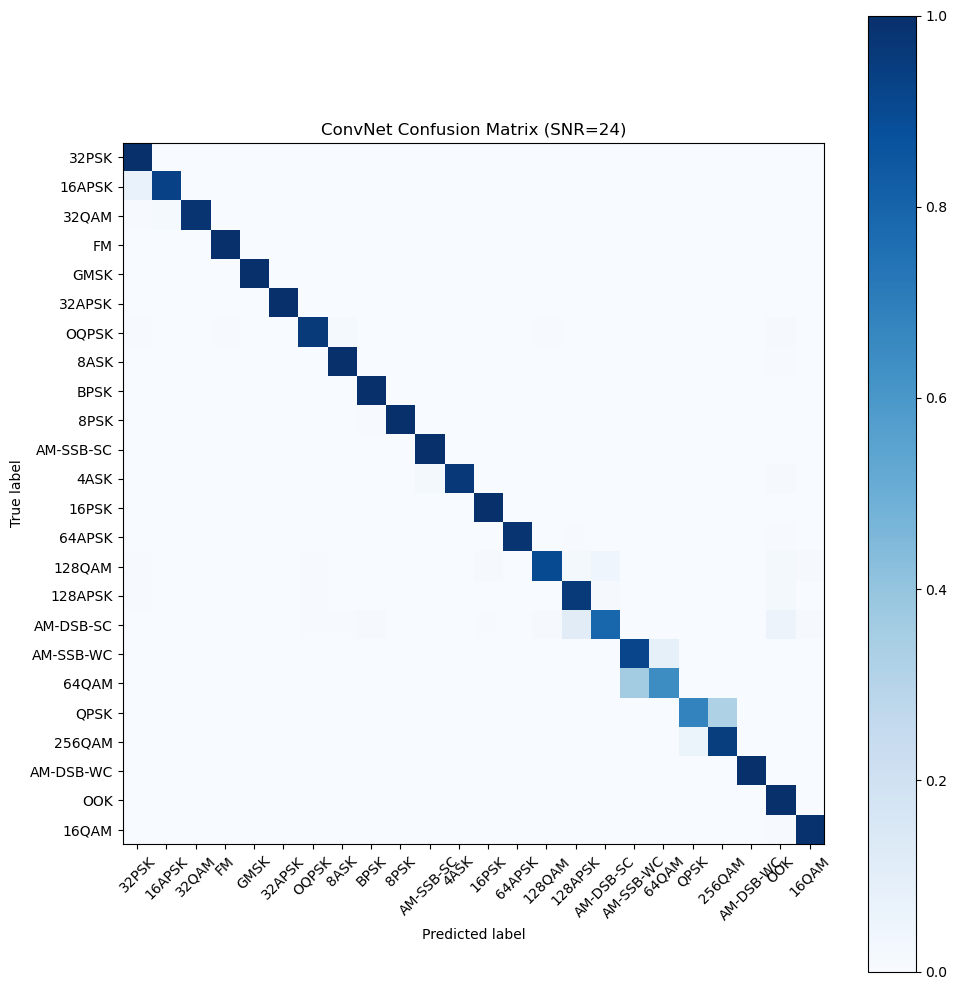

<Figure size 640x480 with 0 Axes>

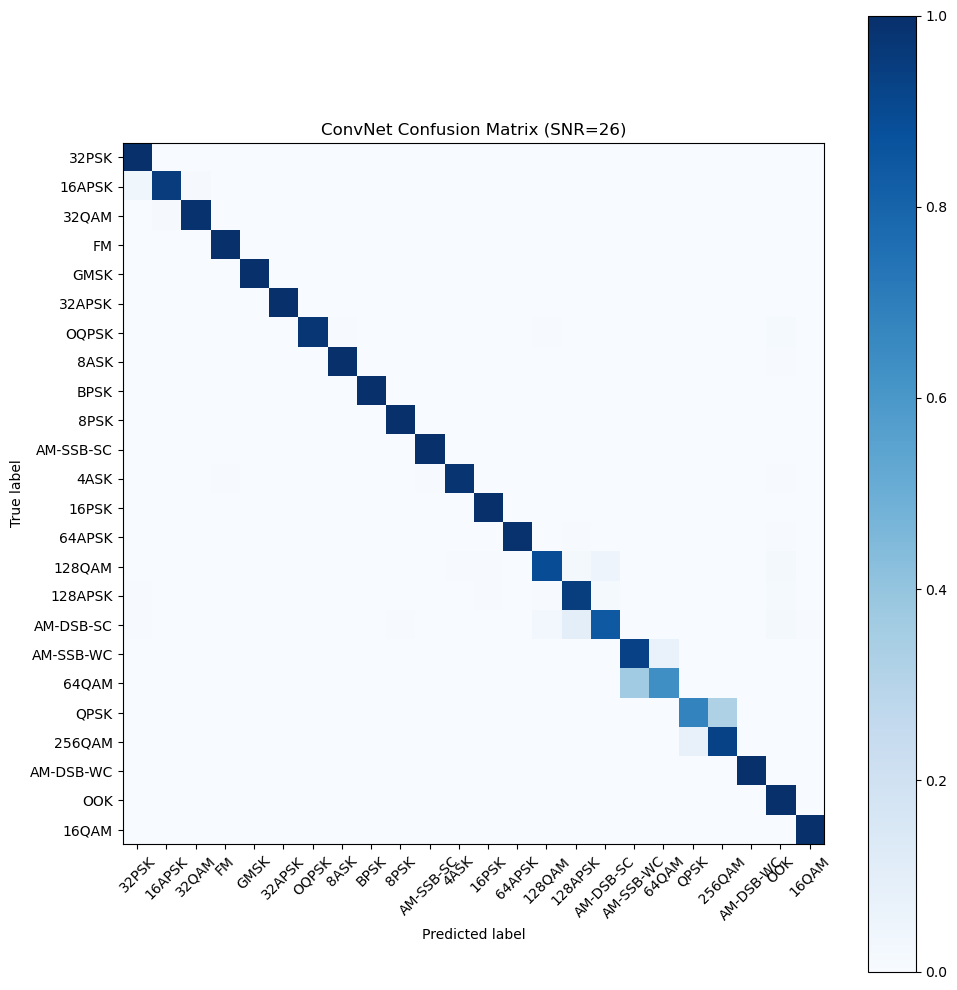

<Figure size 640x480 with 0 Axes>

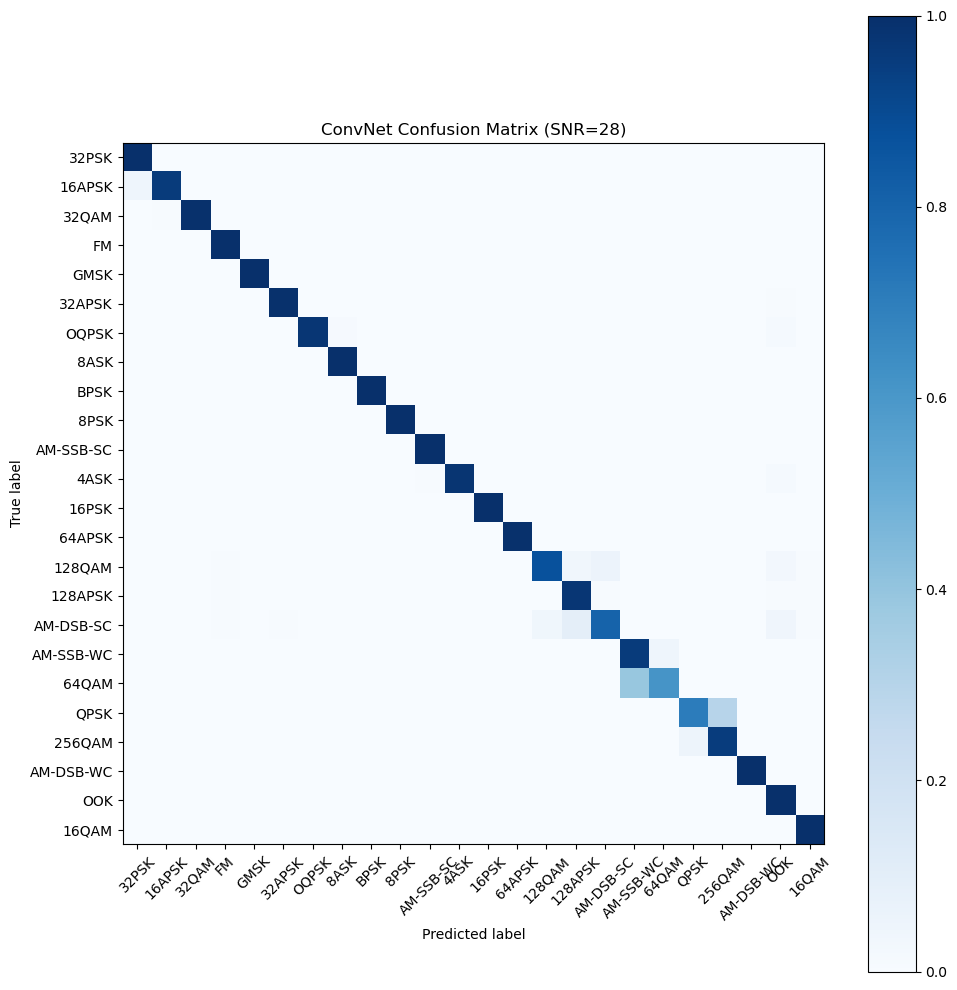

<Figure size 640x480 with 0 Axes>

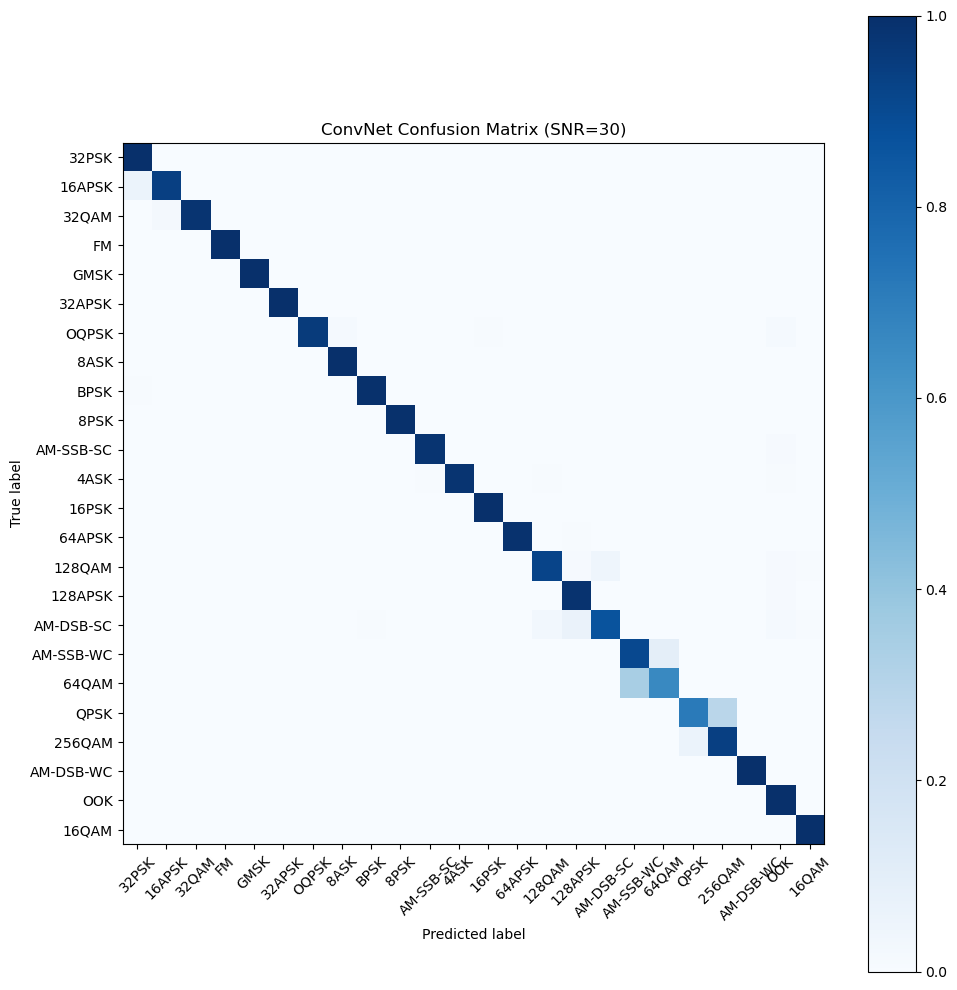

In [7]:
acc={}  # 创建一个字典，用于存储不同信噪比（SNR）下的分类准确率

Z_test = Z[test_idx]  # 从Z中提取测试数据的标签，Z是一个包含所有数据标签的数组，test_idx是测试数据的索引
Z_test = Z_test.reshape((len(Z_test)))  # 将Z_test重塑为一维数组

SNRs = np.unique(Z_test)  # 获取测试数据中唯一的信噪比值

for snr in SNRs:  # 遍历每个信噪比值
    X_test_snr = X_test[Z_test==snr]  # 提取当前信噪比下的测试特征数据
    Y_test_snr = Y_test[Z_test==snr]  # 提取当前信噪比下的测试标签数据
    
    pre_Y_test_resnet = model_resnet.predict(X_test_snr)  # 使用ResNet模型预测当前信噪比下的测试数据
    pre_Y_test_transformer = model_trafo.predict(X_test_snr)  # 使用Transformer模型预测当前信噪比下的测试数据
    
    conf = np.zeros([len(classes),len(classes)])  # 初始化混淆矩阵
    confnorm = np.zeros([len(classes),len(classes)])  # 初始化归一化的混淆矩阵
    
    for i in range(0, X_test_snr.shape[0]):  # 遍历当前信噪比下的所有测试数据
        j = list(Y_test_snr[i,:]).index(1)  # 获取实际标签的索引，假设Y_test_snr是one-hot编码的
        
        # 预测标签的索引，选择两个模型中置信度较高的那个作为最终预测
        if np.max(pre_Y_test_resnet[i,:]) > np.max(pre_Y_test_transformer[i,:]):
            k = int(np.argmax(pre_Y_test_resnet[i,:]))  # 如果ResNet的置信度较高，选择ResNet的预测
        else:
            k = int(np.argmax(pre_Y_test_transformer[i,:]))  # 否则选择Transformer的预测
        
        conf[j,k] = conf[j,k] + 1  # 更新混淆矩阵，实际类别j对应预测类别k的计数加一
    
    for i in range(0, len(classes)):  # 遍历每个类别
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])  # 计算归一化混淆矩阵，每行除以该行的总数
   
    plt.figure()  # 创建一个新图像
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))  # 绘制归一化混淆矩阵，并设置标题为当前信噪比
    
    cor = np.sum(np.diag(conf))  # 计算混淆矩阵的对角线元素之和，即正确分类的样本数
    ncor = np.sum(conf) - cor  # 计算非对角线元素之和，即错误分类的样本数
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))  # 输出当前信噪比下的整体准确率
    acc[snr] = 1.0 * cor / (cor + ncor)  # 将当前信噪比下的准确率存储到字典acc中


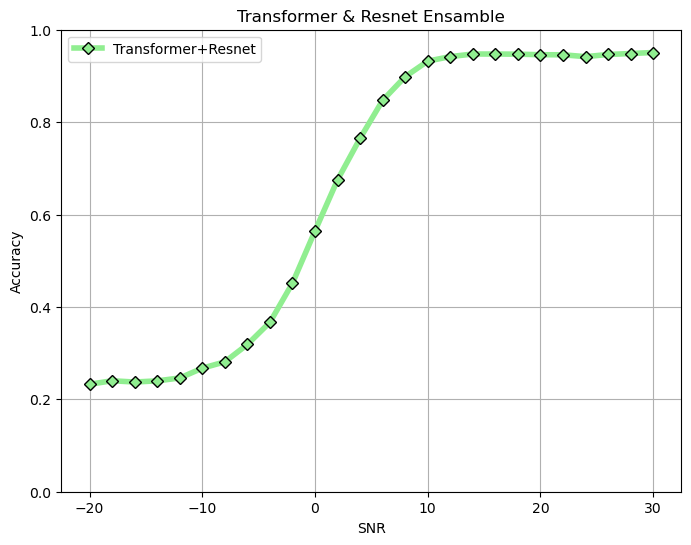

In [8]:
plt.figure(figsize=(8,6))
plt.plot(acc.keys(),acc.values(),linewidth=4,color='lightgreen', marker='D', markeredgecolor='black')
plt.ylim(0, 1) 
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title('Transformer & Resnet Ensamble')
plt.grid()
plt.legend(['Transformer+Resnet'],loc='upper left')
plt.show()